# Implementing a Principal Component Analysis (PCA)

## Introduction

The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of $n$ $d$-dimensional samples) onto a smaller subspace that represents our data "well". A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of the parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data "best".

### What is a "good" subspace?

Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $k$-dimensional subspace (where $k < d$). So, how do we know what size we would choose for $k$, and how do we know if we have a feature space that represents our data "well"? Later, we will compute eigenvectors (the components) from our dataset and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tells us about the "length" or "magnitude" of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a "good" subspace. Or if some of the eigenvalues are much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.

### Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1. Take the whole dataset consisting of $d$-dimensional samples ignoring the class labels
2. Compute the $d$-dimensional mean vector (i.e. the means for every dimension of the whole dataset)
3. Compute the scatter matrix (alternatively, the covariance matrix) of the whole dataset
4. Compute eigenvectors ($e_1,e_2,...,e_d$) and corresponding eigenvalues ($\lambda_1,\lambda_2,...,\lambda_d$)
5. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k$ dimensional matrix $W$ (where every column represents an eigenvector)
6. Use this $d \times k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y=W^T \times x$ (where $x$ is a $d \times 1$-dimensional vector representing one sample, and $y$ is the transformed $k \times 1$-dimensional sample in the new subspace.)

## Generating some 3-dimensional sample data

For the following example, we will generate 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution.

Here we will assume that the samples stem from two different classes, where one half (i.e. 20) samples of our dataset are labeled $\omega_1$ (class 1) and the other half $\omega_2$ (class 2).

$
\mu_1 = 
\begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix} \quad
\mu_2 =
\begin{bmatrix}
1 \\
1 \\
1
\end{bmatrix} \quad
\text{(sample means)}
$

$
\Sigma_1 =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} \quad
\Sigma_2 =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} \quad
\text{(covariance matrices)}
$

### Why are we choosing a 3-dimensional sample?

The problem of multi-dimensional data is its visualization, which would make it quite tough to follow our example principal component analysis (at least visually). We could also choose a 2-dimensional sample dataset for the following examples, but since the goal of the PCA in a "Dimensionality Reduction" application is to drop at least one of the dimensions, I find it more intuitive and visually appealing to start with a 3-dimensional dataset that we reduce to a 2-dimensional dataset by dropping 1 dimension.

In [1]:
import numpy as np

mu_vec1 = np.zeros(3)
cov_mat1 = np.eye(3)
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)
assert class1_sample.shape == (20, 3), "The matrix has not the dimensions 20x3"

mu_vec2 = np.ones(3)
cov_mat2 = np.eye(3)
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)
assert class2_sample.shape == (20, 3), "The matrix has not the dimensions 20x3"

Using the code above, we created two $20 \times 3$ datasets - one dataset for each class $\omega_1$ and $\omega_2$ - where each row can be pictured as a 3-dimensional vector $x = \begin{pmatrix}x_1 \\ x_2 \\ x_3 \end{pmatrix}$ so that our dataset will have the form

$
X = 
\begin{pmatrix}
x_{1_1} & x_{2_1} & x_{3_1}\\
x_{1_2} & x_{2_2} & x_{3_2}\\
... & ... & ...\\
x_{1_{20}} & x_{2_{20}} & x_{3_{20}}\\
\end{pmatrix}
$

Just to get a rough idea how the samples of our two classes $\omega_1$ and $\omega_2$ are distributed, let us plot them in a 3D scatter plot.

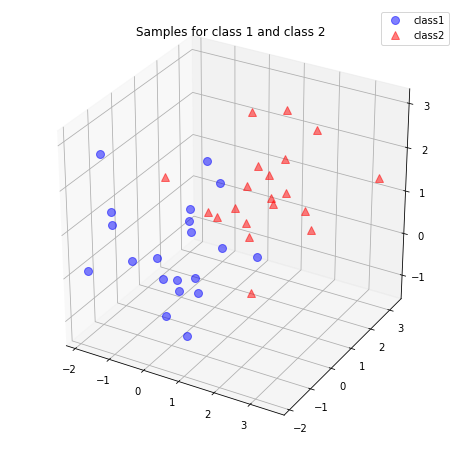

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(class1_sample[:, 0], class1_sample[:, 1], class1_sample[:, 2],
        'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[:, 0], class2_sample[:, 1], class2_sample[:, 2],
        '^', markersize=8, color='red', alpha=0.5, label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## 1. Taking the whole dataset ignoring the class labels

Because we don't need class labels for the PCA analysis, let us merge the samples for our 2 classes into on $40 \times 3$-dimensional array.

In [3]:
all_samples = np.concatenate((class1_sample, class2_sample))
assert all_samples.shape == (40, 3), "The matrix has not the dimensions 40x3"

## 2. Computing the d-dimensional mean vector

In [4]:
mean_vector = np.mean(all_samples, axis=0)
mean_x, mean_y, mean_z = mean_vector
mean_vector

array([0.4994135 , 0.41723551, 0.8787458 ])

## 3. a) Computing the Scatter Matrix

The scatter matrix is computed by the following equation:

$S = \sum_{k=1}^n (x_k-m)^T(x_k-m)$

where $m$ is the mean vector

$m = \frac{1}{n}\sum_{k=1}^n x_k$

In [5]:
scatter_matrix = (all_samples - mean_vector).T.dot(all_samples - mean_vector)
scatter_matrix

array([[63.56994535, 37.53991311, 17.16079008],
       [37.53991311, 58.16490286, 16.47128329],
       [17.16079008, 16.47128329, 48.52091734]])

## 3. b) Computing the Covariance Matrix (alternatively to the scatter matrix)

Alternatively, instead of calculating the scatter matrix, we could also calculate the covariance matrix using the in-built `numpy.cov()` function. The equations for the covariance matrix and scatter matrix are very similar, the only difference is, that we use the scaling factor $\frac{1}{N-1}$ (here: $\frac{1}{40-1} = \frac{1}{39}$) for the covariance matrix. Thus, their ___eigenspaces___ will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

$$
\Sigma_i =
\begin{bmatrix}
\sigma_{11}^2 & \sigma_{12}^2 & \sigma_{13}^2 \\
\sigma_{21}^2 & \sigma_{22}^2 & \sigma_{23}^2 \\
\sigma_{31}^2 & \sigma_{32}^2 & \sigma_{33}^2
\end{bmatrix}
$$

In [6]:
cov_mat = np.cov(all_samples.T)
cov_mat

array([[1.6299986 , 0.96256187, 0.44002026],
       [0.96256187, 1.49140777, 0.4223406 ],
       [0.44002026, 0.4223406 , 1.24412609]])

## 4. Computing eigenvectors and corresponding eigenvalues

To show that the eigenvectors are indeed identical whether we derived them from the scatter or the covariance matrix, let us put an assert statement into the code. Also, we will see that the eigenvalues were indeed scaled by the factor 39 when we derived it from the scatter matrix.

In [7]:
# eigenvectors and eigenvalues from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

np.testing.assert_array_almost_equal(eig_vec_sc, eig_vec_cov, decimal=8, verbose=True,
                                     err_msg='Eigenvectors are not identical')

for i in range(len(eig_val_sc)):
    print(f'Eigenvector {i+1}:\n{eig_vec_sc[:, i]}')
    print(f'Eigenvalue {i+1} from scatter matrix: {eig_val_sc[i]}')
    print(f'Eigenvalue {i+1} from covariance matrix: {eig_val_cov[i]}')
    print(f'Scaling factor: {np.round(eig_val_sc[i] / eig_val_cov[i], decimals=2)}')
    print(40 * '-')

Eigenvector 1:
[-0.67864809 -0.63374394 -0.37122149]
Eigenvalue 1 from scatter matrix: 108.01292953327629
Eigenvalue 1 from covariance matrix: 2.7695622957250334
Scaling factor: 39.0
----------------------------------------
Eigenvector 2:
[-0.67631435  0.73632395 -0.02063835]
Eigenvalue 2 from scatter matrix: 23.222780055530905
Eigenvalue 2 from covariance matrix: 0.5954558988597669
Scaling factor: 39.0
----------------------------------------
Eigenvector 3:
[-0.2864187  -0.23705624  0.92831496]
Eigenvalue 3 from scatter matrix: 39.020055969786384
Eigenvalue 3 from covariance matrix: 1.0005142556355482
Scaling factor: 39.0
----------------------------------------


### Checking the eigenvector-eigenvalue calculation

Let us quickly check that the eigenvector-eigenvalue calculation is correct and satisfy the equation

$$\Sigma v = \lambda v$$

where

-  $\Sigma = \text{Covariance Matrix}$
-  $v = \text{Eigenvector}$
-  $\lambda = \text{Eigenvalue}$

In [8]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:, i]
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

### Visualizing the eigenvectors

And before we move on to the next step, just to satisfy our own curiosity, we plot the eigenvectors centered at the sample mean.

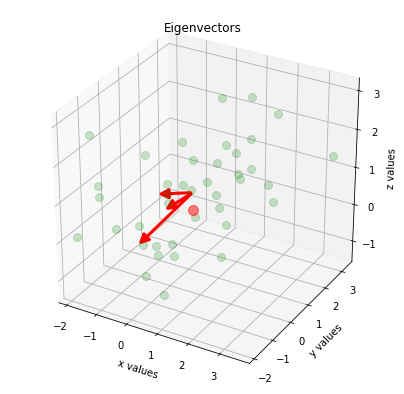

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[:, 0], all_samples[:, 1], all_samples[:, 2],
        'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_y],
        'o', markersize=10, color='red', alpha=0.5)

for eigv in eig_vec_sc.T:
    a = Arrow3D([mean_x, eigv[0]], [mean_y, eigv[1]], [mean_z, eigv[2]],
                mutation_scale=20, lw=3, arrowstyle='-|>', color='r')
    ax.add_artist(a)
    
ax.set_xlabel('x values')
ax.set_ylabel('y values')
ax.set_zlabel('z values')

plt.title('Eigenvectors')
plt.show()

## 5.1. Sorting the eigenvectors by decreasing eigenvalues

We started with the goal to reduce the dimensionality of our feature space, i.e., projecting the feature space via PCA onto a smaller subspace, where the eigenvectors will form the axes of this new feature subspace. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which we can confirm by the following code:

In [10]:
for ev in eig_vec_sc:
    assert(np.isclose(1.0, np.linalg.norm(ev)))

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = list(zip(eig_val_sc, eig_vec_sc.T))

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for eval, _ in eig_pairs:
    print(eval)

108.01292953327629
39.020055969786384
23.222780055530905


## 5.2. Choosing _k_ eigenvectors with the largest eigenvalues

For our simple example, where we are reducing a 3-dimensional feature space to a 2-dimensional feature subspace, we are combining the two eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $W$.

In [12]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(-1, 1), eig_pairs[1][1].reshape(-1, 1)))
matrix_w

array([[-0.67864809, -0.2864187 ],
       [-0.63374394, -0.23705624],
       [-0.37122149,  0.92831496]])

## 6. Transforming the samples onto the new subspace

In the last step, we use the $2 \times 3$-dimensional matrix $W$ that we just computed to transform our samples onto the new subspace via the equation $y = x \cdot W$

In [13]:
transformed = all_samples.dot(matrix_w)
assert transformed.shape == (40, 2), 'The matrix is not 40x2 dimensional.'

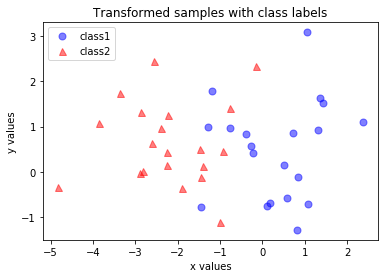

In [14]:
plt.plot(transformed[:20, 0], transformed[:20, 1],
         'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[20:, 0], transformed[20:, 1],
         '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()